### CS4622 Mini Kaggle Competition - Multiclass Image Classification - Shallow Network - Preprocessing, Even Sample Distribution
#### Author: Sabine Hollatz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

import seaborn as sns

In [2]:
X_train = np.load('../../data_comp4/cuboulder-image-labelling/train_and_test/X_train.npy')
y_train = np.load('../../data_comp4/cuboulder-image-labelling/train_and_test/y_train.npy')
X_test = np.load('../../data_comp4/cuboulder-image-labelling/train_and_test/X_test.npy')
num_samples = y_train.shape[0]
num_classes = y_train.shape[1]
print("Number of samples: {}, number of classes: {}".format(num_samples, num_classes))
print("image size: {}x{}x{}".format(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

Number of samples: 39209, number of classes: 43
image size: 32x32x3


In [3]:
# print(y_train[:10])
y_categorical = [np.where(r==1)[0][0] for r in y_train]
print(y_categorical[:100])
unique, counts = np.unique(y_categorical, return_counts=True)
print("unique: {}, counts: {}".format(unique, counts))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42], counts: [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]


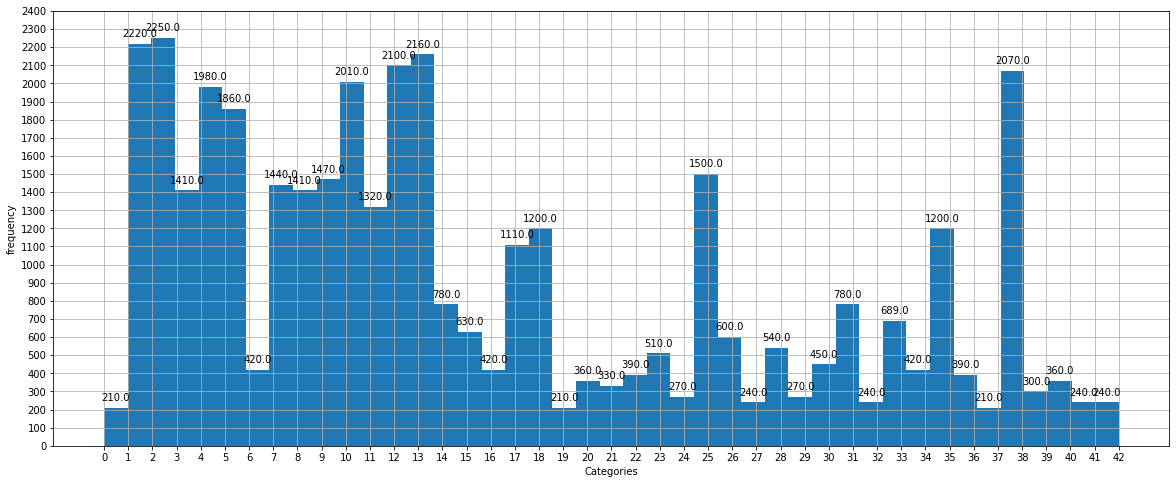

In [4]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize=(20,8))
counts, bins, rects = plt.hist(y_categorical, label="distribution of categories by label", bins = 43)
autolabel(rects)
plt.grid(True)
plt.xticks(np.arange(0, 43, step=1))
plt.yticks(np.arange(0, 2500, step=100))
plt.ylabel('frequency')
plt.xlabel('Categories');

In [5]:
from random import sample 

xy_list = []
xy_tuple = ()
for i in range(num_samples):
    xy_tuple = (X_train[i], y_categorical[i])
    xy_list.append(xy_tuple)

d_all = {el:[] for el in range(num_classes)}
for label in unique:
    for j in range(len(xy_list)):
        if (xy_list[j][1] == label):
            d_all[label].append(xy_list[j])

d_subsamples = {el:[] for el in range(num_classes)} 
for k in range(num_classes):
    d_subsamples[k] = (sample(d_all[k],210))
    
subsamples = []
for key, value in d_subsamples.items():
    for pair in value:
        subsamples.append(pair)

In [6]:
subsamples_shuffled = sample(subsamples, len(subsamples)) 

X_subsamples = []
y_subsamples = []
for r in range(len(subsamples_shuffled)):
    X_subsamples.append(subsamples_shuffled[r][0])
    y_subsamples.append(subsamples_shuffled[r][1])
print(y_subsamples[:10])

[18, 37, 0, 37, 3, 42, 0, 19, 35, 38]


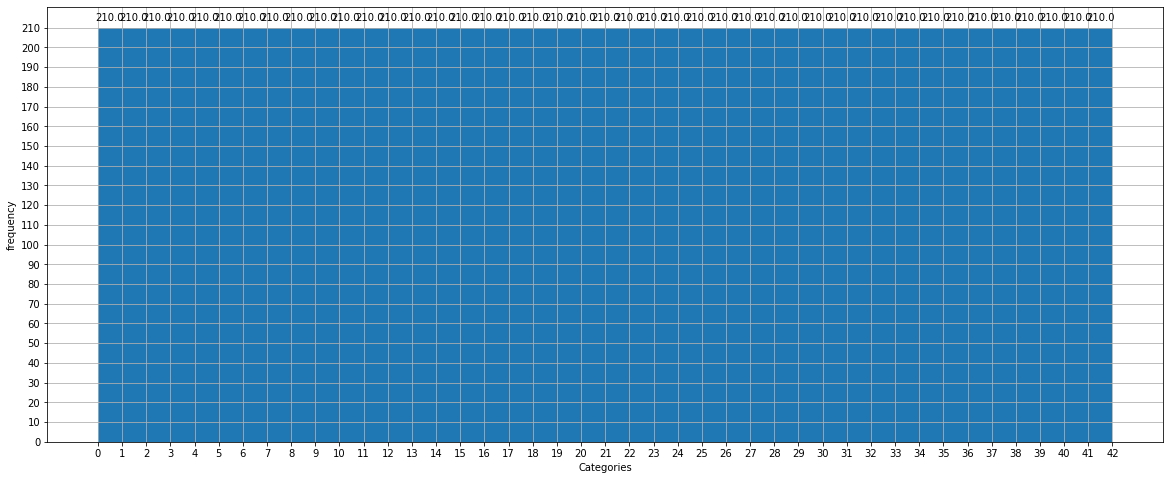

In [7]:
fig, ax = plt.subplots(figsize=(20,8))
counts2, bins2, rects2 = plt.hist(y_subsamples, label="distribution of categories by label", bins = 43)
autolabel(rects2)
plt.grid(True)
plt.xticks(np.arange(0, 43, step=1))
plt.yticks(np.arange(0, 220, step=10))
plt.ylabel('frequency')
plt.xlabel('Categories');

In [8]:
from tensorflow.keras.utils import to_categorical   
one_hot_subsamples = subsamples
one_hot_subsamples = to_categorical(y_subsamples, num_classes=43)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(np.array(X_subsamples), one_hot_subsamples, test_size=0.2)

In [10]:
print(y_train_sub.shape)
print(X_train_sub.shape)

(7224, 43)
(7224, 32, 32, 3)


In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    data_format = "channels_last")

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    data_format = "channels_last")

In [12]:
train_datagen_sub = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    zoom_range=0.2,
    rotation_range=10,
    shear_range=0.2,
    fill_mode='nearest',
    data_format = "channels_last")

val_datagen_sub = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=[-20,20],
    height_shift_range=0.5,
    brightness_range=[0.2,1.0],
    zoom_range=0.2,
    rotation_range=10,
    shear_range=0.2,
    fill_mode='nearest',
    data_format = "channels_last")

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[32,32,3]),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(43, activation="softmax"),
])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=5)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])

epochs = 30
batchsize = 128

history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batchsize), 
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=batchsize),
                    steps_per_epoch=len(X_train) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245.0546875 steps, validate for 62 steps
Epoch 1/30
246/245 [==============================] - 169s 688ms/step - loss: 3.5744 - categorical_accuracy: 0.0516 - val_loss: 3.5277 - val_categorical_accuracy: 0.0639
Epoch 2/30
246/245 [==============================] - 167s 680ms/step - loss: 3.2810 - categorical_accuracy: 0.0978 - val_loss: 2.4607 - val_categorical_accuracy: 0.2494
Epoch 3/30
246/245 [==============================] - 169s 688ms/step - loss: 2.1258 - categorical_accuracy: 0.3325 - val_loss: 1.3801 - val_categorical_accuracy: 0.5171
Epoch 4/30
246/245 [==============================] - 172s 698ms/step - loss: 1.3724 - categorical_accuracy: 0.5231 - val_loss: 0.8465 - val_categorical_accuracy: 0.7021
Epoch 5/30
246/245 [==============================] - 173s 703ms/step - loss: 0.9768 - categorical_accuracy: 0.6549 - val_loss: 0.5608 - val_categorical_accuracy: 0.7893
Epoch 6/30
246/245 [=============================

In [15]:
model_sub = model
history_sub = model_sub.fit(train_datagen_sub.flow(X_train_sub, y_train_sub, batch_size=batchsize), 
                    validation_data=val_datagen_sub.flow(X_val_sub, y_val_sub, batch_size=batchsize),
                    steps_per_epoch=len(X_train_sub) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 56.4375 steps, validate for 15 steps
Epoch 1/30
57/56 [==============================] - 47s 816ms/step - loss: 1.9762 - categorical_accuracy: 0.4929 - val_loss: 5.0795 - val_categorical_accuracy: 0.0266
Epoch 2/30
57/56 [==============================] - 46s 812ms/step - loss: 1.0017 - categorical_accuracy: 0.7205 - val_loss: 5.1560 - val_categorical_accuracy: 0.0288
Epoch 3/30
57/56 [==============================] - 46s 812ms/step - loss: 0.7711 - categorical_accuracy: 0.7957 - val_loss: 4.8940 - val_categorical_accuracy: 0.0266
Epoch 4/30
57/56 [==============================] - 46s 814ms/step - loss: 0.6361 - categorical_accuracy: 0.8350 - val_loss: 5.1210 - val_categorical_accuracy: 0.0205
Epoch 5/30
57/56 [==============================] - 46s 812ms/step - loss: 0.5374 - categorical_accuracy: 0.8565 - val_loss: 4.9737 - val_categorical_accuracy: 0.0216
Epoch 6/30
57/56 [==============================] - 46s 813ms/step -

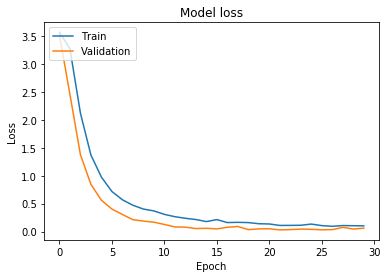

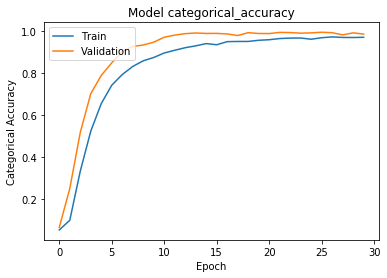

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model categorical_accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

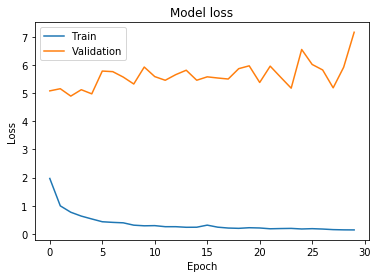

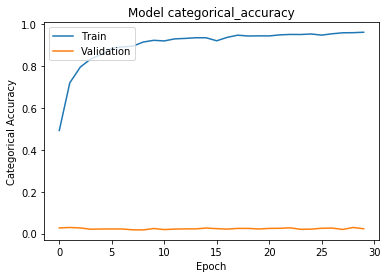

In [17]:
# Plot training & validation loss values
plt.plot(history_sub.history['loss'])
plt.plot(history_sub.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_sub.history['categorical_accuracy'])
plt.plot(history_sub.history['val_categorical_accuracy'])
plt.title('Model categorical_accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
predictions = model.predict(X_test)
predictions_sub = model_sub.predict(X_test)

In [19]:
preds_to_submit = pd.DataFrame(predictions.astype('int'))
preds_to_submit_sub = pd.DataFrame(predictions_sub.astype('int'))
preds_to_submit

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12626,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
12627,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12628,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
preds_to_submit.to_csv("./shallow_CNN_predictions.csv")
preds_to_submit_sub.to_csv("./shallow_CNN_predictions_sub.csv")